# Fowl Escapades

This notebook shows a quick example submission to the 'Fowl Escapades' challenge on Zindi. 

It's not necessarily a good submission, but it does take you through the whole process. Loading the data, processing the audio into features (spectrograms, in this case) and making a submission.

I hope it's useful :)

# Load the labels

I'm assuming you've extracted test.zip and train.zip, and downloaded the CSV files from Zindi.

Here we'll generate a couple of dataframes with the labels for train and paths to the images.

In [ ]:
"""
apt-get install libsndfile1-dev
apt-get update

conda install -c conda-forge ffmpeg

"""

In [1]:
!ls

StarterNotebook-Copy1.ipynb  submission_starter_notebook.csv
StarterNotebook.ipynb	     submission_starter_notebook_resnet18.csv
data			     submission_starter_notebook_resnet50.csv
models


In [2]:
import pandas as pd
import os

In [3]:
from pandarallel import pandarallel


In [4]:
pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
sub = pd.read_csv('data/SampleSubmission.csv')
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train = pd.read_csv('data/Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [7]:
# This list will be useful later
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [8]:
# Add file names
train['file_name'] = 'data/train/'+train['ID']+'.mp3'
sub['file_name'] = 'data/test/'+sub['ID']+'.mp3'

train['image_path'] = 'data/train/'+train['ID']+'.png'
sub['image_path'] = 'data/test/'+sub['ID']+'.png'


# Generate features

There are many ways to tackle this challenge. Try deep learning on the audio, generate a spectrogram and treat this as an image classification task, use some signal processing tricks to look for close matches, try to extract meaningful features such as dominant frequencies.... It's up to you :)

This blog (https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d) shows how to visualize different properties of the waveform, and some features you could use. 

For this example, I'll generate a square spectrogram and save as an image file - not a very elegant approach but let's see where it gets us.

In [9]:
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa

/opt/conda/envs/fastai/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/conda/envs/fastai/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [10]:
#listen to a sound
pth = train['file_name'].sample(1).values[0]
pth


'data/train/ZFHUXT.mp3'

In [11]:
!ls data/train/WNARUZ.mp3

data/train/WNARUZ.mp3


/opt/conda/envs/fastai/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


data/train/ZFHUXT.png


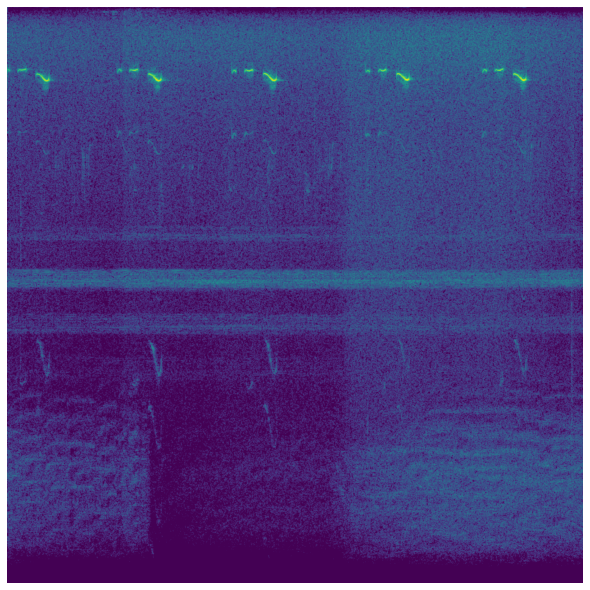

In [12]:
# Going from a sound to an image: spectrograms

def gen_spectrogram(path):
    x , sr = librosa.load(path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])
    fig = plt.figure(frameon=False)
    fig.set_size_inches(8, 8)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(Xdb, aspect='auto')
    fig.savefig(path[:-4]+'.png', dpi=512//8)
    print(path[:-4]+'.png')

gen_spectrogram(pth)

In [13]:
def create_spectorgram(pth):
    if not os.path.isfile(pth[:-4]+'.png'):
        plt.clf()
        gen_spectrogram(pth)
        #ipd.clear_output(wait=True)
        #plt.close()

In [14]:
train['file_name'].parallel_apply(create_spectorgram )

0       None
1       None
2       None
3       None
4       None
        ... 
1852    None
1853    None
1854    None
1855    None
1856    None
Name: file_name, Length: 1857, dtype: object

In [15]:
sub['file_name'].parallel_apply(create_spectorgram )

0      None
1      None
2      None
3      None
4      None
       ... 
906    None
907    None
908    None
909    None
910    None
Name: file_name, Length: 911, dtype: object

In [16]:
train['file_name'].values[0:5]

array(['data/train/MBMG2C.mp3', 'data/train/K8LJSB.mp3',
       'data/train/OGD9L6.mp3', 'data/train/581PCQ.mp3',
       'data/train/P91M1F.mp3'], dtype=object)

In [17]:
sub['file_name'][0:5]

0    data/test/019OYB.mp3
1    data/test/01S9OX.mp3
2    data/test/02CS12.mp3
3    data/test/02LM3W.mp3
4    data/test/0C3A2V.mp3
Name: file_name, dtype: object

In [18]:
# This takes a long time to run, and you might have to do it in batches. Save the spectrogras for future runs!
import numpy as np
import os
for i, pth in enumerate(np.concatenate([train['file_name'].values, sub['file_name'].values])):
    print(i*100//(len(sub)+len(train)), '% done')
    # Check if we've already generated a spectrogram, and if not, make one
  
    if not os.path.isfile(pth[:-4]+'.png'):
        plt.clf()
        gen_spectrogram(pth)
    ipd.clear_output(wait=True)
    plt.close()

95 % done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob('data/train/*.png')
print(len(ims), len(train))

1857 1857


# Modelling

I use a model pre-trained on imagenet, and throw the spectrograms at it. Not the most elegant approach, but it will do for now!

In [20]:
from fastai.vision import *

In [21]:
train

,ID,common_name,file_name,image_path
0,MBMG2C,Ring-necked Dove,data/train/MBMG2C.mp3,data/train/MBMG2C.png
1,K8LJSB,Ring-necked Dove,data/train/K8LJSB.mp3,data/train/K8LJSB.png
2,OGD9L6,Ring-necked Dove,data/train/OGD9L6.mp3,data/train/OGD9L6.png
3,581PCQ,Ring-necked Dove,data/train/581PCQ.mp3,data/train/581PCQ.png
4,P91M1F,Ring-necked Dove,data/train/P91M1F.mp3,data/train/P91M1F.png
...,...,...,...,...
1852,0NBCLO,Cape Bunting,data/train/0NBCLO.mp3,data/train/0NBCLO.png
1853,74EQ14,Cape Bunting,data/train/74EQ14.mp3,data/train/74EQ14.png
1854,XFPUW9,Cape Bunting,data/train/XFPUW9.mp3,data/train/XFPUW9.png
1855,6TM36Z,Cape Bunting,data/train/6TM36Z.mp3,data/train/6TM36Z.png


In [22]:
np.random.seed(42)

data = ImageDataBunch.from_df(path=".", df=train[["image_path", "common_name"]], ds_tfms=get_transforms(), size=330, num_workers=4)\
  .split_by_rand_pct()\
  .label_from_df(cols='common_name')\
  .databunch(bs=16)\
  .normalize(imagenet_stats)

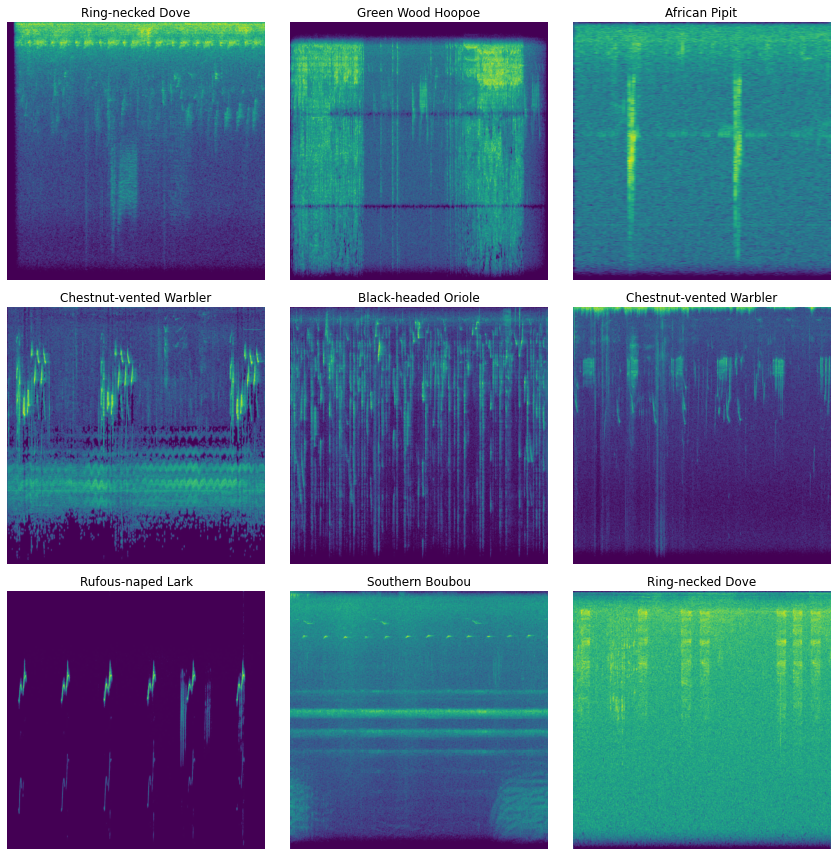

In [23]:
data.show_batch(rows=3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


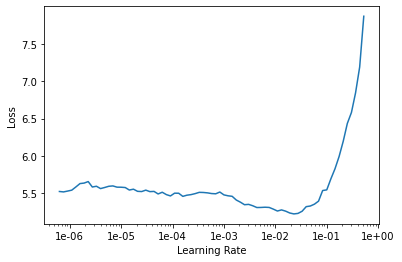

In [26]:
# Create a learner and pick a learning rate
learn = cnn_learner(data, models.resnet152, metrics=[error_rate, accuracy, top_k_accuracy])
learn.lr_find()
learn.recorder.plot()

In [27]:
# Train the head of the model
lr = 1e-3
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.697378,3.646279,0.828283,0.171717,0.397306,01:22
1,3.424102,2.857126,0.734007,0.265993,0.589226,01:21
2,2.182186,2.636261,0.676768,0.323232,0.639731,01:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


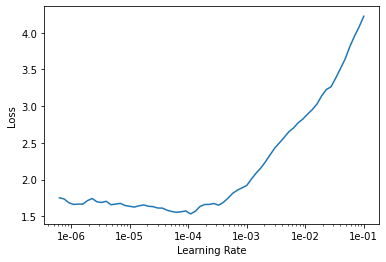

In [28]:
# Not doing very well yet. Let's train the inner layers
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.653777,2.554494,0.666667,0.333333,0.643098,01:45
1,1.430677,2.401150,0.622896,0.377104,0.707071,01:45
2,0.984214,2.238312,0.595960,0.404040,0.717172,01:46


### An accuracy of 32% seems bad, but consider that this is across 40 classes. The model guesses the right bird in its top 5 guesses 60% of the time! You can boost this significantly with a little more training and a larger image size. This approach is crazy, but it kinda works!!!

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Making a submission

Save the model's predicted probabilities to a file following the sample submission format. This can be submitted on Zindi.

In [ ]:
test

In [ ]:
# Add the test data as a test set for the model
src = (ImageList.from_df(path='.', df=sub, cols='image_path')) # Note test, not sub, as we only have spectrograms for the ims in test
learn.data.add_test(src)

In [ ]:
# Get predictions
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
# Add preds to test
test = sub.copy()
for b in birds:
    test[b] = preds[:,learn.data.classes.index(b)]
test.head()

In [ ]:
# Merge back into submission DF, adding a low prob prediction for rows where we had no image generated
cols = ['ID']
for b in birds:
    cols.append(b)
ss = pd.merge(sub['ID'], test[cols], on='ID', how='left' )
ss = ss.fillna(1/40) # For those with NaNs (if you only generated spectrograms for a subset of the test mp3s)
ss.head()

In [ ]:
# Check shape
ss.shape

In [ ]:
# Save 
ss.to_csv('submission_starter_notebook_resnet152.csv', index=False)

# How To Get Better

Hopefully, this has got you started and given you an idea of what the data for this competition looks like. The submission we've just generated should score ~2.7 on the leaderboard (the validation loss tracks pretty closely with the Zindi score since it's also log_loss). But where do you go from here? Here are some ideas:

### 1) Refining the process above

The above method (training an image classifier on spectrograms) can do decently. Some ways to improve the score:
- Increase the image size
- Train a little more, or try different models
- 'Crop' the inputs, both to show a shorter clip of audio and a smaller frequency range
- Experiment with different ways of displaying the spectrgram. Log scale on the frequency axis. More striking colour maps. Maybe some audio cleaning and pre-processing...

### 2) Extracting other features

Look at other approaches people take for audio ML tasks. Mel Spectrograms, amplitude plots, various acoustic parameters... there's a whole world of audio-related weirdness you can explore. These kinds of features can then be fed into your ML algorithm of choice. 

### 3) Boost training data quality by detecting 'events'

Consider the following image:

![spectrogram image](https://www.xeno-canto.org/sounds/uploaded/XRABICUARW/ffts/XC3962-large.png)

You can see four clear signals (calls) separated by noise. You'll notice this in many of the training recordings. Rather than ~30 recordings per species, you could find a way to detect such events and clip the audio files, to give you hundreds of exaple calls, each neatly isolated from the longer recordings. This has the potential to massively improve performance. 

### 4) Tackle 'background calls'

I haven't explored this avenue at all, but finding a way to account for the occasional presence of extra birds calling in the background when making your predictions might give you a slight extra edge.

### 5) Make friends with someone who does Signal Processing

There are signal processing techniques that seem like magic to anyone not used to thinking in the fourier domain. I don't have specific recommendations for things to check out here, but if you do happen to know somebody with skills in this area I suspect it'll be worth offering them a share of your glory in exchange for some tips. :)

### 6) Look around to see what the State of the Art is for audio classification

Using an image recognition pipeline for audio classification is a bit of a hack. Take a look at some recent publications to see what the cool kids are using. 

### 7) Get creative!

I'm hoping the winner doesn't just take some of the advice above and follow a standard bird call classification path. There are so many ways to approach this problem, and the best way is likely still undiscovered!

Good luck :)